In [1]:
# Import all packages needed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import json
from pathlib import Path
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Import style.json
style_path: Path = Path.cwd().parent / 'style' / 'style.json'
with open(style_path, 'r') as f: # opens the style.json file
    style: dict = json.load(f) # loads as a dictionary object

In [3]:
# Loading Data (data file must be in the same directory as jupyter notebook)
# Import data from excel file
raw_data_filename: str ='2024_09_11_imine polymer t=0hrs FeCl3 solution doping.csv'
raw_data_filename1: str ='2024_09_11_imine polymer t=1hrs FeCl3 solution doping.csv'
raw_data_filename4: str ='2024_09_11_imine polymer t=3hrs FeCl3 solution doping.csv'
raw_data_filename5: str ='2024_09_11_imine polymer t=5hrs FeCl3 solution doping.csv'
raw_data_filename24: str ='2024_09_12_imine t=24hrs FeCl3 doping.csv'

# Tell program to read the data
raw_data: pd.DataFrame = pd.read_csv(raw_data_filename) # read data into a pandas dataframe

# Output data
raw_data

,t=0hrs FeCl3 0uM,Unnamed: 1,t=0hrs FeCl3 20uM,Unnamed: 3,t=0hrs FeCl3 50uM,Unnamed: 5,t=0hrs FeCl3 100uM,Unnamed: 7,t=0hrs FeCl3 5uM repeat,Unnamed: 9,Unnamed: 10
0,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,NaN
1,1400,0.006113265641,1400,0.006079952233,1400,0.005114572123,1400,0.005455367267,1400,0.002385277534,NaN
2,1399.333374,0.005727728829,1399.333374,0.005872776732,1399.333374,0.005101921503,1399.333374,0.005729853641,1399.333374,0.002406491432,NaN
3,1398.666626,0.005660297815,1398.666626,0.005528875161,1398.666626,0.004912726581,1398.666626,0.005182285327,1398.666626,0.002089980291,NaN
4,1398,0.00534316292,1398,0.005099616479,1398,0.004388543777,1398,0.004595849197,1398,0.001800238155,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1802,End Method Modifications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1803,<Current Wavelength>,300.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1804,<SBW (nm)>,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1805,<Energy>,57.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Data preprocessing specific to UV-Vis
#TODO: baseline correction?
# TODO: normalize as an option
def preprocess(data: pd.DataFrame, normalize: bool = True, baseline: bool = True):
    """Function that applies transformation to the dataframe which will make it ready for plotting. Note, this is specific to UV-Vis.
    """
    # Drop row with index = 0
    data = data.drop(labels=0, axis=0) # drop row with index = 0

    # Drop additional information
    indexes = data[data.columns[0]].str.find("Collection Time:") # find the index of the row with the string "Collection Time:"
    first_occurrence: int = indexes[indexes==0.0].index[0] # find the index of the first occurrence of the string "Collection Time:"
    data = data.drop(labels=range(first_occurrence-3, len(data.index)+1), axis=0) # drop the rows with the additional information

    # Rename column names (y-data)
    column_rename: dict = {}
    for i in range(1, len(data.columns), 2): # loop through every other column
        column_rename[data.columns[i]] = data.columns[i-1] + "_Abs" # rename every other column by adding _Abs
    data = data.rename(columns=column_rename) # rename the columns

    # Rename column name (x-data)
    data = data.rename(columns={data.columns[0]: "Wavelength (nm)"}) # rename the first column to "Wavelength (nm)"

    # Baseline correction
    if baseline: # if baseline is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                data[col] = data[col] - np.average(data[col][0:50]) # subtract the average of the first 50 data points from every absorbance value

    # Normalize absorbance values
    if normalize: # if normalize is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                max_val: float = data[col].max() # find the maximum absorbance value
                data[col] = data[col] / max_val # divide every absorbance value by the maximum absorbance value
    return data

# NOTE: change True to False if you don't want normalization or baseline correction
preprocessed_data: pd.DataFrame = preprocess(raw_data, False, False)
preprocessed_data

,Wavelength (nm),t=0hrs FeCl3 0uM_Abs,t=0hrs FeCl3 20uM,t=0hrs FeCl3 20uM_Abs,t=0hrs FeCl3 50uM,t=0hrs FeCl3 50uM_Abs,t=0hrs FeCl3 100uM,t=0hrs FeCl3 100uM_Abs,t=0hrs FeCl3 5uM repeat,t=0hrs FeCl3 5uM repeat_Abs,Unnamed: 10
1,1400,0.006113265641,1400,0.006079952233,1400,0.005114572123,1400,0.005455367267,1400,0.002385277534,NaN
2,1399.333374,0.005727728829,1399.333374,0.005872776732,1399.333374,0.005101921503,1399.333374,0.005729853641,1399.333374,0.002406491432,NaN
3,1398.666626,0.005660297815,1398.666626,0.005528875161,1398.666626,0.004912726581,1398.666626,0.005182285327,1398.666626,0.002089980291,NaN
4,1398,0.00534316292,1398,0.005099616479,1398,0.004388543777,1398,0.004595849197,1398,0.001800238155,NaN
5,1397.333374,0.004933671094,1397.333374,0.004402141552,1397.333374,0.003783723339,1397.333374,0.003742780769,1397.333374,0.001210508402,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1646,303.3333435,0.2403757423,303.3333435,0.2945780754,303.3333435,0.3790470064,303.3333435,0.5482578278,303.3333435,0.2512487173,NaN
1647,302.6666565,0.2361278981,302.6666565,0.290171355,302.6666565,0.3742422163,302.6666565,0.5427895188,302.6666565,0.2471388578,NaN
1648,302,0.2323866785,302,0.2862802446,302,0.3702137768,302,0.5381706953,302,0.2432101667,NaN
1649,301.3333435,0.2285123765,301.3333435,0.2820769846,301.3333435,0.3660731018,301.3333435,0.5334401727,301.3333435,0.2393128723,NaN


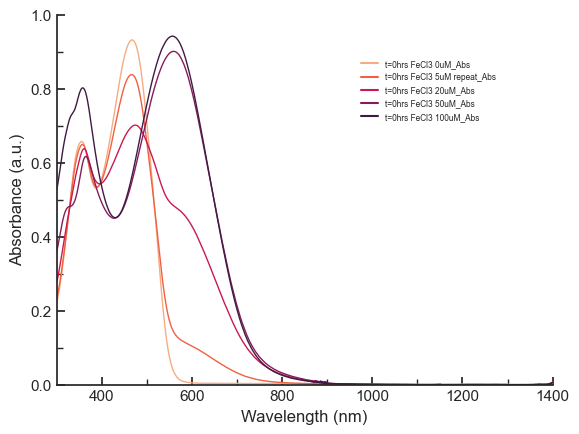

In [5]:
# Plot the data!
# NOTE: User must change the sample names to the correct column names.
sample_name_to_plot: list[str] = [
    "t=0hrs FeCl3 0uM_Abs",
    "t=0hrs FeCl3 5uM repeat_Abs",
    "t=0hrs FeCl3 20uM_Abs",
    "t=0hrs FeCl3 50uM_Abs",
    "t=0hrs FeCl3 100uM_Abs"
]

# If you want to rename, uncomment and insert here!
# sample_name_rename: dict = {"2023_06_22_C10-dialdehyde-chcl3_Abs": "RENAME", "2023_06_22_benzene-diphosphonate1_Abs": "RENAME", "2023_06_22_fluorene-diphosphonate_Abs": "RENAME", "2023_06_22_model-compound_Abs" : "RENAME", "2023_06_22_AU-038-A2-3_Abs" : "RENAME"}
# preprocessed_data = preprocessed_data.rename(columns=sample_name_rename)
# Convert to "tidy" form
plot_data: pd.DataFrame = pd.melt(
    preprocessed_data,
    id_vars=["Wavelength (nm)"],
    value_vars=sample_name_to_plot,
    var_name="sample",
    value_name="Absorbance (a.u.)",
)

# Set correct dtypes
plot_data = plot_data.astype(
    {"Wavelength (nm)": "float32", "sample": "str", "Absorbance (a.u.)": "float32"}
)

# seaborn styles
sns.set_style("ticks")
sns.set_context("notebook") # gives the blank white background theme
# sns.set_theme(context="notebook", style="white", font="Helvetica")

graph = sns.lineplot(
    data=plot_data, # refers to dataframe that contains the data
    x="Wavelength (nm)", # refers to column header to get all the X data
    y="Absorbance (a.u.)", # refers to column header to get all the Y data
    hue="sample",
    palette="rocket_r",  #NOTE: User can change the palette here
    linewidth=style["graph"]["default"]["line_thickness"], # refers to the thickness of the line in the graph (this is set in the style.json file)
)
sns.despine() # this removes the top and right spines of the graph

graph.legend(
    fontsize=style["legend"]["font_size"], # refers to the font size of the legend (this is set in the style.json file)
    bbox_to_anchor=(0.9, 0.9), # refers to the position of the legend anchored in the figure
    title_fontsize=style["legend"]["title_font_size"], # refers to the font size of the legend title
    shadow=False, # refers to whether the legend has a shadow or not
    frameon=False, # refers to whether the legend has a frame or not
)
# font family
plt.rcParams['font.family'] = style["graph"]["default"]["font_family"] # refers to the font family of the text in the graph (this is set in the style.json file)

# y-axis and x-axis ticks
graph.xaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in X-axis
graph.yaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in Y-axis
graph.tick_params(axis="y", direction="in") # direction of major ticks in Y-axis
graph.tick_params(axis="x", direction="in") # direction of major ticks in X-axis
graph.tick_params(axis="y", which="minor", length=4, direction="in") # direction and length of minor ticks in Y-axis
graph.tick_params(axis="x", which="minor", length=4, direction="in") # direction and length of minor ticks in X-axis

# NOTE: User can change the x and y limits here
plt.xlim(300, 1400)
# NOTE: User can change the y limits here
plt.ylim(0, 1.0)

# Save the figure
# NOTE: User can change the filename
plt.savefig("2024_09_11 imine FeCl3 doping.svg", dpi=300, bbox_inches="tight")
plt.savefig("2024_09_11 imine FeCl3 doping.jpg", dpi=300, bbox_inches="tight")


In [6]:
# Tell program to read the data
raw_data1: pd.DataFrame = pd.read_csv(raw_data_filename1) # read data into a pandas dataframe

# Data preprocessing specific to UV-Vis
#TODO: baseline correction?
# TODO: normalize as an option
def preprocess(data: pd.DataFrame, normalize: bool = True, baseline: bool = True):
    """Function that applies transformation to the dataframe which will make it ready for plotting. Note, this is specific to UV-Vis.
    """
    # Drop row with index = 0
    data = data.drop(labels=0, axis=0) # drop row with index = 0

    # Drop additional information
    indexes = data[data.columns[0]].str.find("Collection Time:") # find the index of the row with the string "Collection Time:"
    first_occurrence: int = indexes[indexes==0.0].index[0] # find the index of the first occurrence of the string "Collection Time:"
    data = data.drop(labels=range(first_occurrence-3, len(data.index)+1), axis=0) # drop the rows with the additional information

    # Rename column names (y-data)
    column_rename: dict = {}
    for i in range(1, len(data.columns), 2): # loop through every other column
        column_rename[data.columns[i]] = data.columns[i-1] + "_Abs" # rename every other column by adding _Abs
    data = data.rename(columns=column_rename) # rename the columns

    # Rename column name (x-data)
    data = data.rename(columns={data.columns[0]: "Wavelength (nm)"}) # rename the first column to "Wavelength (nm)"

    # Baseline correction
    if baseline: # if baseline is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                data[col] = data[col] - np.average(data[col][0:50]) # subtract the average of the first 50 data points from every absorbance value

    # Normalize absorbance values
    if normalize: # if normalize is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                max_val: float = data[col].max() # find the maximum absorbance value
                data[col] = data[col] / max_val # divide every absorbance value by the maximum absorbance value
    return data

# NOTE: change True to False if you don't want normalization or baseline correction
preprocessed_data1: pd.DataFrame = preprocess(raw_data1, False, False)
preprocessed_data1

,Wavelength (nm),t=1hrs FeCl3 0uM_Abs,t=1hrs FeCl3 5uM,t=1hrs FeCl3 5uM_Abs,t=1hrs FeCl3 20uM,t=1hrs FeCl3 20uM_Abs,t=1hrs FeCl3 50uM,t=1hrs FeCl3 50uM_Abs,t=1hrs FeCl3 100uM,t=1hrs FeCl3 100uM_Abs,Unnamed: 10
1,1400,0.002932768315,1400,0.003999047913,1400,0.007985242642,1400,0.004499821458,1400,0.004501992371,NaN
2,1399.333374,0.003084080992,1399.333374,0.004150497261,1399.333374,0.007992625237,1399.333374,0.004634648096,1399.333374,0.004589335062,NaN
3,1398.666626,0.002727896208,1398.666626,0.003648403334,1398.666626,0.007302548736,1398.666626,0.003917126451,1398.666626,0.00425936142,NaN
4,1398,0.002153841546,1398,0.003162455745,1398,0.006632333621,1398,0.003524947446,1398,0.003669104539,NaN
5,1397.333374,0.001344084041,1397.333374,0.002408339642,1397.333374,0.005457805004,1397.333374,0.002550381934,1397.333374,0.002925080247,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1646,303.3333435,0.2407558262,303.3333435,0.2583048046,303.3333435,0.3049162924,303.3333435,0.3920364976,303.3333435,0.5401992798,NaN
1647,302.6666565,0.2364280224,302.6666565,0.2539824247,302.6666565,0.3003117442,302.6666565,0.3870473802,302.6666565,0.5343145728,NaN
1648,302,0.2328294218,302,0.2501413822,302,0.2963482738,302,0.382761687,302,0.5290395617,NaN
1649,301.3333435,0.2291451991,301.3333435,0.2460642457,301.3333435,0.2923653722,301.3333435,0.3780353963,301.3333435,0.523188889,NaN


In [7]:
# Tell program to read the data
raw_data4: pd.DataFrame = pd.read_csv(raw_data_filename4) # read data into a pandas dataframe

# Data preprocessing specific to UV-Vis
#TODO: baseline correction?
# TODO: normalize as an option
def preprocess(data: pd.DataFrame, normalize: bool = True, baseline: bool = True):
    """Function that applies transformation to the dataframe which will make it ready for plotting. Note, this is specific to UV-Vis.
    """
    # Drop row with index = 0
    data = data.drop(labels=0, axis=0) # drop row with index = 0

    # Drop additional information
    indexes = data[data.columns[0]].str.find("Collection Time:") # find the index of the row with the string "Collection Time:"
    first_occurrence: int = indexes[indexes==0.0].index[0] # find the index of the first occurrence of the string "Collection Time:"
    data = data.drop(labels=range(first_occurrence-3, len(data.index)+1), axis=0) # drop the rows with the additional information

    # Rename column names (y-data)
    column_rename: dict = {}
    for i in range(1, len(data.columns), 2): # loop through every other column
        column_rename[data.columns[i]] = data.columns[i-1] + "_Abs" # rename every other column by adding _Abs
    data = data.rename(columns=column_rename) # rename the columns

    # Rename column name (x-data)
    data = data.rename(columns={data.columns[0]: "Wavelength (nm)"}) # rename the first column to "Wavelength (nm)"

    # Baseline correction
    if baseline: # if baseline is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                data[col] = data[col] - np.average(data[col][0:50]) # subtract the average of the first 50 data points from every absorbance value

    # Normalize absorbance values
    if normalize: # if normalize is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                max_val: float = data[col].max() # find the maximum absorbance value
                data[col] = data[col] / max_val # divide every absorbance value by the maximum absorbance value
    return data

# NOTE: change True to False if you don't want normalization or baseline correction
preprocessed_data4: pd.DataFrame = preprocess(raw_data4, False, False)
preprocessed_data4

,Wavelength (nm),t=3hrs FeCl3 0uM_Abs,t=3hrs FeCl3 5uM,t=3hrs FeCl3 5uM_Abs,t=3hrs FeCl3 20uM,t=3hrs FeCl3 20uM_Abs,t=3hrs FeCl3 50uM,t=3hrs FeCl3 50uM_Abs,t=3hrs FeCl3 100uM,t=3hrs FeCl3 100uM_Abs,Unnamed: 10
1,1400,0.006133428309,1400,0.006036036648,1400,0.01029208396,1400,0.006262670737,1400,0.006186018698,NaN
2,1399.333374,0.006071026903,1399.333374,0.006039816421,1399.333374,0.0101116905,1399.333374,0.006531912833,1399.333374,0.006311757024,NaN
3,1398.666626,0.005892482121,1398.666626,0.00549959112,1398.666626,0.009538435377,1398.666626,0.005792599637,1398.666626,0.0058652726,NaN
4,1398,0.005439272616,1398,0.005173902493,1398,0.008965805173,1398,0.005510496907,1398,0.005615900271,NaN
5,1397.333374,0.005034116097,1397.333374,0.004435457289,1397.333374,0.008056542836,1397.333374,0.004718380049,1397.333374,0.004928408656,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1646,303.3333435,0.2387606949,303.3333435,0.2631064355,303.3333435,0.3229750693,303.3333435,0.4307312369,303.3333435,0.5742856264,NaN
1647,302.6666565,0.2345047295,302.6666565,0.2604664564,302.6666565,0.3195447922,302.6666565,0.4254998565,302.6666565,0.5677146912,NaN
1648,302,0.2307328731,302,0.2580715716,302,0.3167250752,302,0.4203102887,302,0.5614245534,NaN
1649,301.3333435,0.2273513824,301.3333435,0.2564365268,301.3333435,0.3139578104,301.3333435,0.4156084359,301.3333435,0.555560112,NaN


In [8]:
# Tell program to read the data
raw_data5: pd.DataFrame = pd.read_csv(raw_data_filename5) # read data into a pandas dataframe

# Data preprocessing specific to UV-Vis
#TODO: baseline correction?
# TODO: normalize as an option
def preprocess(data: pd.DataFrame, normalize: bool = True, baseline: bool = True):
    """Function that applies transformation to the dataframe which will make it ready for plotting. Note, this is specific to UV-Vis.
    """
    # Drop row with index = 0
    data = data.drop(labels=0, axis=0) # drop row with index = 0

    # Drop additional information
    indexes = data[data.columns[0]].str.find("Collection Time:") # find the index of the row with the string "Collection Time:"
    first_occurrence: int = indexes[indexes==0.0].index[0] # find the index of the first occurrence of the string "Collection Time:"
    data = data.drop(labels=range(first_occurrence-3, len(data.index)+1), axis=0) # drop the rows with the additional information

    # Rename column names (y-data)
    column_rename: dict = {}
    for i in range(1, len(data.columns), 2): # loop through every other column
        column_rename[data.columns[i]] = data.columns[i-1] + "_Abs" # rename every other column by adding _Abs
    data = data.rename(columns=column_rename) # rename the columns

    # Rename column name (x-data)
    data = data.rename(columns={data.columns[0]: "Wavelength (nm)"}) # rename the first column to "Wavelength (nm)"

    # Baseline correction
    if baseline: # if baseline is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                data[col] = data[col] - np.average(data[col][0:50]) # subtract the average of the first 50 data points from every absorbance value

    # Normalize absorbance values
    if normalize: # if normalize is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                max_val: float = data[col].max() # find the maximum absorbance value
                data[col] = data[col] / max_val # divide every absorbance value by the maximum absorbance value
    return data

# NOTE: change True to False if you don't want normalization or baseline correction
preprocessed_data5: pd.DataFrame = preprocess(raw_data5, False, False)
preprocessed_data5

,Wavelength (nm),t=5hrs FeCl3 0uM_Abs,t=5hrs FeCl3 5uM,t=5hrs FeCl3 5uM_Abs,t=5hrs FeCl3 20uM,t=5hrs FeCl3 20uM_Abs,t=5hrs FeCl3 50uM,t=5hrs FeCl3 50uM_Abs,t=5hrs FeCl3 100uM,t=5hrs FeCl3 100uM_Abs,Unnamed: 10
1,1400,0.007548282389,1400,0.006600872613,1400,0.009736222215,1400,0.005599956959,1400,0.007254824042,NaN
2,1399,0.006920768414,1399,0.006304586772,1399,0.008976560086,1399,0.005182626192,1399,0.006991552189,NaN
3,1398,0.006713796407,1398,0.005759573076,1398,0.008253286593,1398,0.004882515408,1398,0.006566811819,NaN
4,1397,0.006259203888,1397,0.005282106344,1397,0.007515069097,1397,0.004481879063,1397,0.006246441044,NaN
5,1396,0.005603811704,1396,0.00454300642,1396,0.006543922238,1396,0.003918380011,1396,0.005672204308,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1096,305,0.2503858209,305,0.2738573551,305,0.3480513096,305,0.4651726782,305,0.6042920351,NaN
1097,304,0.2438274324,304,0.270283252,304,0.342299819,304,0.4550100565,304,0.592469573,NaN
1098,303,0.2376132607,303,0.2671685815,303,0.3370410502,303,0.4458115399,303,0.5820876956,NaN
1099,302,0.2319351584,302,0.2637696564,302,0.3321758509,302,0.4370503724,302,0.5719236135,NaN


In [9]:
# Tell program to read the data
raw_data24: pd.DataFrame = pd.read_csv(raw_data_filename24) # read data into a pandas dataframe

# Data preprocessing specific to UV-Vis
#TODO: baseline correction?
# TODO: normalize as an option
def preprocess(data: pd.DataFrame, normalize: bool = True, baseline: bool = True):
    """Function that applies transformation to the dataframe which will make it ready for plotting. Note, this is specific to UV-Vis.
    """
    # Drop row with index = 0
    data = data.drop(labels=0, axis=0) # drop row with index = 0

    # Drop additional information
    indexes = data[data.columns[0]].str.find("Collection Time:") # find the index of the row with the string "Collection Time:"
    first_occurrence: int = indexes[indexes==0.0].index[0] # find the index of the first occurrence of the string "Collection Time:"
    data = data.drop(labels=range(first_occurrence-3, len(data.index)+1), axis=0) # drop the rows with the additional information

    # Rename column names (y-data)
    column_rename: dict = {}
    for i in range(1, len(data.columns), 2): # loop through every other column
        column_rename[data.columns[i]] = data.columns[i-1] + "_Abs" # rename every other column by adding _Abs
    data = data.rename(columns=column_rename) # rename the columns

    # Rename column name (x-data)
    data = data.rename(columns={data.columns[0]: "Wavelength (nm)"}) # rename the first column to "Wavelength (nm)"

    # Baseline correction
    if baseline: # if baseline is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                data[col] = data[col] - np.average(data[col][0:50]) # subtract the average of the first 50 data points from every absorbance value

    # Normalize absorbance values
    if normalize: # if normalize is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                max_val: float = data[col].max() # find the maximum absorbance value
                data[col] = data[col] / max_val # divide every absorbance value by the maximum absorbance value
    return data

# NOTE: change True to False if you don't want normalization or baseline correction
preprocessed_data24: pd.DataFrame = preprocess(raw_data24, False, False)
preprocessed_data24

,Wavelength (nm),imine t=24hrs FeCl3 0uM_Abs,imine t=24hrs FeCl3 5uM,imine t=24hrs FeCl3 5uM_Abs,imine t=24hrs FeCl3 20uM,imine t=24hrs FeCl3 20uM_Abs,imine t=24hrs FeCl3 50uM,imine t=24hrs FeCl3 50uM_Abs,imine t=24hrs FeCl3 100uM,imine t=24hrs FeCl3 100uM_Abs,Unnamed: 10
1,1200,-0.02813793905,1200,-0.03133233637,1200,-0.03002645634,1200,-0.0238025412,1200,-0.02304706909,NaN
2,1199.333374,-0.02819019556,1199.333374,-0.03134977072,1199.333374,-0.03006075695,1199.333374,-0.02381758578,1199.333374,-0.02308963239,NaN
3,1198.666626,-0.02818544209,1198.666626,-0.0313564688,1198.666626,-0.03007544391,1198.666626,-0.02383331768,1198.666626,-0.02311663143,NaN
4,1198,-0.0282528773,1198,-0.03135497496,1198,-0.03014490567,1198,-0.02380430512,1198,-0.02317901887,NaN
5,1197.333374,-0.02832389064,1197.333374,-0.03143694624,1197.333374,-0.03022411093,1197.333374,-0.0238165576,1197.333374,-0.02323756926,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1420,253.9999542,-0.009318184108,253.9999542,3.975759983,253.9999542,3.515354872,253.9999542,4.260424614,253.9999542,3.038444042,NaN
1421,253.3332977,-0.008343816735,253.3332977,3.886286259,253.3332977,3.431349277,253.3332977,4.187025547,253.3332977,2.965673208,NaN
1422,252.666626,-0.00742752105,252.666626,3.845611811,252.666626,3.390998363,252.666626,4.158400536,252.666626,2.934658051,NaN
1423,251.9999542,-0.006602712907,251.9999542,3.774258375,251.9999542,3.339301586,251.9999542,4.071862221,251.9999542,2.899921179,NaN


In [10]:
combined_data=pd.concat([preprocessed_data24, preprocessed_data5,preprocessed_data4, preprocessed_data1, preprocessed_data], ignore_index=True)
combined_data

,Wavelength (nm),imine t=24hrs FeCl3 0uM_Abs,imine t=24hrs FeCl3 5uM,imine t=24hrs FeCl3 5uM_Abs,imine t=24hrs FeCl3 20uM,imine t=24hrs FeCl3 20uM_Abs,imine t=24hrs FeCl3 50uM,imine t=24hrs FeCl3 50uM_Abs,imine t=24hrs FeCl3 100uM,imine t=24hrs FeCl3 100uM_Abs,...,t=1hrs FeCl3 100uM_Abs,t=0hrs FeCl3 0uM_Abs,t=0hrs FeCl3 20uM,t=0hrs FeCl3 20uM_Abs,t=0hrs FeCl3 50uM,t=0hrs FeCl3 50uM_Abs,t=0hrs FeCl3 100uM,t=0hrs FeCl3 100uM_Abs,t=0hrs FeCl3 5uM repeat,t=0hrs FeCl3 5uM repeat_Abs
0,1200,-0.02813793905,1200,-0.03133233637,1200,-0.03002645634,1200,-0.0238025412,1200,-0.02304706909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1199.333374,-0.02819019556,1199.333374,-0.03134977072,1199.333374,-0.03006075695,1199.333374,-0.02381758578,1199.333374,-0.02308963239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1198.666626,-0.02818544209,1198.666626,-0.0313564688,1198.666626,-0.03007544391,1198.666626,-0.02383331768,1198.666626,-0.02311663143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1198,-0.0282528773,1198,-0.03135497496,1198,-0.03014490567,1198,-0.02380430512,1198,-0.02317901887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1197.333374,-0.02832389064,1197.333374,-0.03143694624,1197.333374,-0.03022411093,1197.333374,-0.0238165576,1197.333374,-0.02323756926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7469,303.3333435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.2403757423,303.3333435,0.2945780754,303.3333435,0.3790470064,303.3333435,0.5482578278,303.3333435,0.2512487173
7470,302.6666565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.2361278981,302.6666565,0.290171355,302.6666565,0.3742422163,302.6666565,0.5427895188,302.6666565,0.2471388578
7471,302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.2323866785,302,0.2862802446,302,0.3702137768,302,0.5381706953,302,0.2432101667
7472,301.3333435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.2285123765,301.3333435,0.2820769846,301.3333435,0.3660731018,301.3333435,0.5334401727,301.3333435,0.2393128723


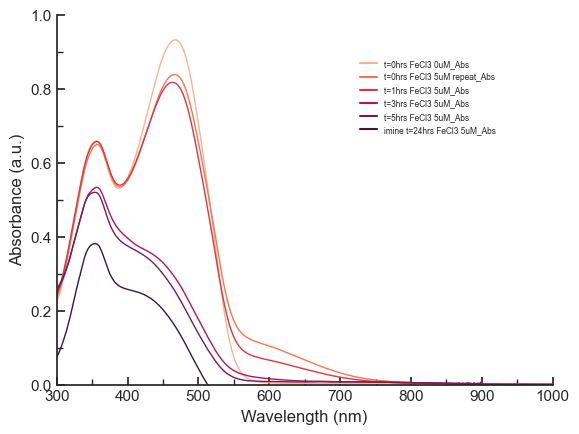

In [11]:
# Plot the data!
# NOTE: User must change the sample names to the correct column names.
sample_name_to_plot: list[str] = [
    "t=0hrs FeCl3 0uM_Abs",
    "t=0hrs FeCl3 5uM repeat_Abs",
    "t=1hrs FeCl3 5uM_Abs",
    "t=3hrs FeCl3 5uM_Abs",
    "t=5hrs FeCl3 5uM_Abs",
    "imine t=24hrs FeCl3 5uM_Abs"
]

# If you want to rename, uncomment and insert here!
# sample_name_rename: dict = {"2023_06_22_C10-dialdehyde-chcl3_Abs": "RENAME", "2023_06_22_benzene-diphosphonate1_Abs": "RENAME", "2023_06_22_fluorene-diphosphonate_Abs": "RENAME", "2023_06_22_model-compound_Abs" : "RENAME", "2023_06_22_AU-038-A2-3_Abs" : "RENAME"}
# preprocessed_data = preprocessed_data.rename(columns=sample_name_rename)
# Convert to "tidy" form
plot_data: pd.DataFrame = pd.melt(
    combined_data,
    id_vars=["Wavelength (nm)"],
    value_vars=sample_name_to_plot,
    var_name="sample",
    value_name="Absorbance (a.u.)",
)

# Set correct dtypes
plot_data = plot_data.astype(
    {"Wavelength (nm)": "float32", "sample": "str", "Absorbance (a.u.)": "float32"}
)

# seaborn styles
sns.set_style("ticks")
sns.set_context("notebook") # gives the blank white background theme
# sns.set_theme(context="notebook", style="white", font="Helvetica")

graph = sns.lineplot(
    data=plot_data, # refers to dataframe that contains the data
    x="Wavelength (nm)", # refers to column header to get all the X data
    y="Absorbance (a.u.)", # refers to column header to get all the Y data
    hue="sample",
    palette="rocket_r",  #NOTE: User can change the palette here
    linewidth=style["graph"]["default"]["line_thickness"], # refers to the thickness of the line in the graph (this is set in the style.json file)
)
sns.despine() # this removes the top and right spines of the graph

graph.legend(
    fontsize=style["legend"]["font_size"], # refers to the font size of the legend (this is set in the style.json file)
    bbox_to_anchor=(0.9, 0.9), # refers to the position of the legend anchored in the figure
    title_fontsize=style["legend"]["title_font_size"], # refers to the font size of the legend title
    shadow=False, # refers to whether the legend has a shadow or not
    frameon=False, # refers to whether the legend has a frame or not
)
# font family
plt.rcParams['font.family'] = style["graph"]["default"]["font_family"] # refers to the font family of the text in the graph (this is set in the style.json file)

# y-axis and x-axis ticks
graph.xaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in X-axis
graph.yaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in Y-axis
graph.tick_params(axis="y", direction="in") # direction of major ticks in Y-axis
graph.tick_params(axis="x", direction="in") # direction of major ticks in X-axis
graph.tick_params(axis="y", which="minor", length=4, direction="in") # direction and length of minor ticks in Y-axis
graph.tick_params(axis="x", which="minor", length=4, direction="in") # direction and length of minor ticks in X-axis

# NOTE: User can change the x and y limits here
plt.xlim(300, 1000)
# NOTE: User can change the y limits here
plt.ylim(0, 1.0)

# Save the figure
# NOTE: User can change the filename
plt.savefig("2024_09_11 imine 5 uM FeCl3 doping.svg", dpi=300, bbox_inches="tight")
plt.savefig("2024_09_11 imine 5 uM FeCl3 doping.jpg", dpi=300, bbox_inches="tight")

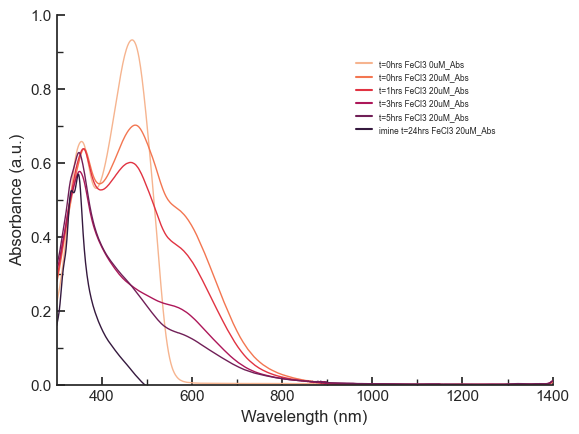

In [12]:
# Plot the data!
# NOTE: User must change the sample names to the correct column names.
sample_name_to_plot: list[str] = [
    "t=0hrs FeCl3 0uM_Abs",
    "t=0hrs FeCl3 20uM_Abs",
    "t=1hrs FeCl3 20uM_Abs",
    "t=3hrs FeCl3 20uM_Abs",
    "t=5hrs FeCl3 20uM_Abs",
    "imine t=24hrs FeCl3 20uM_Abs"
]

# If you want to rename, uncomment and insert here!
# sample_name_rename: dict = {"2023_06_22_C10-dialdehyde-chcl3_Abs": "RENAME", "2023_06_22_benzene-diphosphonate1_Abs": "RENAME", "2023_06_22_fluorene-diphosphonate_Abs": "RENAME", "2023_06_22_model-compound_Abs" : "RENAME", "2023_06_22_AU-038-A2-3_Abs" : "RENAME"}
# preprocessed_data = preprocessed_data.rename(columns=sample_name_rename)
# Convert to "tidy" form
plot_data: pd.DataFrame = pd.melt(
    combined_data,
    id_vars=["Wavelength (nm)"],
    value_vars=sample_name_to_plot,
    var_name="sample",
    value_name="Absorbance (a.u.)",
)

# Set correct dtypes
plot_data = plot_data.astype(
    {"Wavelength (nm)": "float32", "sample": "str", "Absorbance (a.u.)": "float32"}
)

# seaborn styles
sns.set_style("ticks")
sns.set_context("notebook") # gives the blank white background theme
# sns.set_theme(context="notebook", style="white", font="Helvetica")

graph = sns.lineplot(
    data=plot_data, # refers to dataframe that contains the data
    x="Wavelength (nm)", # refers to column header to get all the X data
    y="Absorbance (a.u.)", # refers to column header to get all the Y data
    hue="sample",
    palette="rocket_r",  #NOTE: User can change the palette here
    linewidth=style["graph"]["default"]["line_thickness"], # refers to the thickness of the line in the graph (this is set in the style.json file)
)
sns.despine() # this removes the top and right spines of the graph

graph.legend(
    fontsize=style["legend"]["font_size"], # refers to the font size of the legend (this is set in the style.json file)
    bbox_to_anchor=(0.9, 0.9), # refers to the position of the legend anchored in the figure
    title_fontsize=style["legend"]["title_font_size"], # refers to the font size of the legend title
    shadow=False, # refers to whether the legend has a shadow or not
    frameon=False, # refers to whether the legend has a frame or not
)
# font family
plt.rcParams['font.family'] = style["graph"]["default"]["font_family"] # refers to the font family of the text in the graph (this is set in the style.json file)

# y-axis and x-axis ticks
graph.xaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in X-axis
graph.yaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in Y-axis
graph.tick_params(axis="y", direction="in") # direction of major ticks in Y-axis
graph.tick_params(axis="x", direction="in") # direction of major ticks in X-axis
graph.tick_params(axis="y", which="minor", length=4, direction="in") # direction and length of minor ticks in Y-axis
graph.tick_params(axis="x", which="minor", length=4, direction="in") # direction and length of minor ticks in X-axis

# NOTE: User can change the x and y limits here
plt.xlim(300, 1400)
# NOTE: User can change the y limits here
plt.ylim(0, 1.0)

# Save the figure
# NOTE: User can change the filename
plt.savefig("2024_09_11 imine 20 uM FeCl3 doping.svg", dpi=300, bbox_inches="tight")
plt.savefig("2024_09_11 imine 20 uM FeCl3 doping.jpg", dpi=300, bbox_inches="tight")

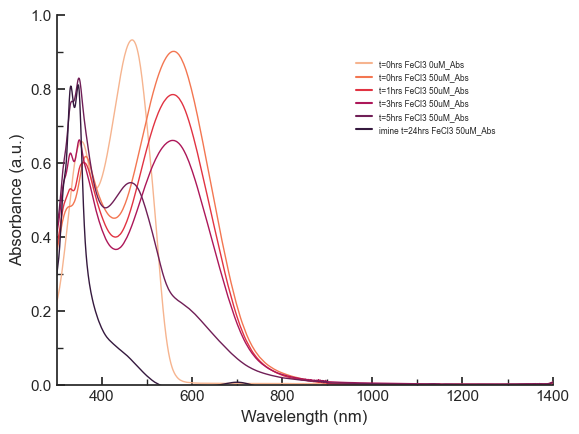

In [13]:
# Plot the data!
# NOTE: User must change the sample names to the correct column names.
sample_name_to_plot: list[str] = [
    "t=0hrs FeCl3 0uM_Abs",
    "t=0hrs FeCl3 50uM_Abs",
    "t=1hrs FeCl3 50uM_Abs",
    "t=3hrs FeCl3 50uM_Abs",
    "t=5hrs FeCl3 50uM_Abs",
    "imine t=24hrs FeCl3 50uM_Abs"
]

# If you want to rename, uncomment and insert here!
# sample_name_rename: dict = {"2023_06_22_C10-dialdehyde-chcl3_Abs": "RENAME", "2023_06_22_benzene-diphosphonate1_Abs": "RENAME", "2023_06_22_fluorene-diphosphonate_Abs": "RENAME", "2023_06_22_model-compound_Abs" : "RENAME", "2023_06_22_AU-038-A2-3_Abs" : "RENAME"}
# preprocessed_data = preprocessed_data.rename(columns=sample_name_rename)
# Convert to "tidy" form
plot_data: pd.DataFrame = pd.melt(
    combined_data,
    id_vars=["Wavelength (nm)"],
    value_vars=sample_name_to_plot,
    var_name="sample",
    value_name="Absorbance (a.u.)",
)

# Set correct dtypes
plot_data = plot_data.astype(
    {"Wavelength (nm)": "float32", "sample": "str", "Absorbance (a.u.)": "float32"}
)

# seaborn styles
sns.set_style("ticks")
sns.set_context("notebook") # gives the blank white background theme
# sns.set_theme(context="notebook", style="white", font="Helvetica")

graph = sns.lineplot(
    data=plot_data, # refers to dataframe that contains the data
    x="Wavelength (nm)", # refers to column header to get all the X data
    y="Absorbance (a.u.)", # refers to column header to get all the Y data
    hue="sample",
    palette="rocket_r",  #NOTE: User can change the palette here
    linewidth=style["graph"]["default"]["line_thickness"], # refers to the thickness of the line in the graph (this is set in the style.json file)
)
sns.despine() # this removes the top and right spines of the graph

graph.legend(
    fontsize=style["legend"]["font_size"], # refers to the font size of the legend (this is set in the style.json file)
    bbox_to_anchor=(0.9, 0.9), # refers to the position of the legend anchored in the figure
    title_fontsize=style["legend"]["title_font_size"], # refers to the font size of the legend title
    shadow=False, # refers to whether the legend has a shadow or not
    frameon=False, # refers to whether the legend has a frame or not
)
# font family
plt.rcParams['font.family'] = style["graph"]["default"]["font_family"] # refers to the font family of the text in the graph (this is set in the style.json file)

# y-axis and x-axis ticks
graph.xaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in X-axis
graph.yaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in Y-axis
graph.tick_params(axis="y", direction="in") # direction of major ticks in Y-axis
graph.tick_params(axis="x", direction="in") # direction of major ticks in X-axis
graph.tick_params(axis="y", which="minor", length=4, direction="in") # direction and length of minor ticks in Y-axis
graph.tick_params(axis="x", which="minor", length=4, direction="in") # direction and length of minor ticks in X-axis

# NOTE: User can change the x and y limits here
plt.xlim(300, 1400)
# NOTE: User can change the y limits here
plt.ylim(0, 1.0)

# Save the figure
# NOTE: User can change the filename
plt.savefig("2024_09_11 imine 50 uM FeCl3 doping.svg", dpi=300, bbox_inches="tight")
plt.savefig("2024_09_11 imine 50 uM FeCl3 doping.jpg", dpi=300, bbox_inches="tight")

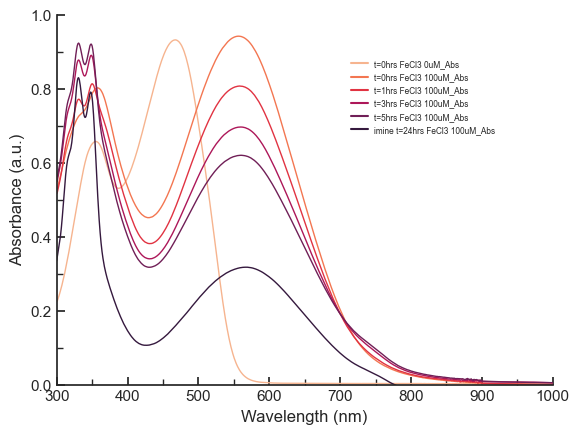

In [14]:
# Plot the data!
# NOTE: User must change the sample names to the correct column names.
sample_name_to_plot: list[str] = [
    "t=0hrs FeCl3 0uM_Abs",
    "t=0hrs FeCl3 100uM_Abs",
    "t=1hrs FeCl3 100uM_Abs",
    "t=3hrs FeCl3 100uM_Abs",
    "t=5hrs FeCl3 100uM_Abs", 
    "imine t=24hrs FeCl3 100uM_Abs"
]

# If you want to rename, uncomment and insert here!
# sample_name_rename: dict = {"2023_06_22_C10-dialdehyde-chcl3_Abs": "RENAME", "2023_06_22_benzene-diphosphonate1_Abs": "RENAME", "2023_06_22_fluorene-diphosphonate_Abs": "RENAME", "2023_06_22_model-compound_Abs" : "RENAME", "2023_06_22_AU-038-A2-3_Abs" : "RENAME"}
# preprocessed_data = preprocessed_data.rename(columns=sample_name_rename)
# Convert to "tidy" form
plot_data: pd.DataFrame = pd.melt(
    combined_data,
    id_vars=["Wavelength (nm)"],
    value_vars=sample_name_to_plot,
    var_name="sample",
    value_name="Absorbance (a.u.)",
)

# Set correct dtypes
plot_data = plot_data.astype(
    {"Wavelength (nm)": "float32", "sample": "str", "Absorbance (a.u.)": "float32"}
)

# seaborn styles
sns.set_style("ticks")
sns.set_context("notebook") # gives the blank white background theme
# sns.set_theme(context="notebook", style="white", font="Helvetica")

graph = sns.lineplot(
    data=plot_data, # refers to dataframe that contains the data
    x="Wavelength (nm)", # refers to column header to get all the X data
    y="Absorbance (a.u.)", # refers to column header to get all the Y data
    hue="sample",
    palette="rocket_r",  #NOTE: User can change the palette here
    linewidth=style["graph"]["default"]["line_thickness"], # refers to the thickness of the line in the graph (this is set in the style.json file)
)
sns.despine() # this removes the top and right spines of the graph

graph.legend(
    fontsize=style["legend"]["font_size"], # refers to the font size of the legend (this is set in the style.json file)
    bbox_to_anchor=(0.9, 0.9), # refers to the position of the legend anchored in the figure
    title_fontsize=style["legend"]["title_font_size"], # refers to the font size of the legend title
    shadow=False, # refers to whether the legend has a shadow or not
    frameon=False, # refers to whether the legend has a frame or not
)
# font family
plt.rcParams['font.family'] = style["graph"]["default"]["font_family"] # refers to the font family of the text in the graph (this is set in the style.json file)

# y-axis and x-axis ticks
graph.xaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in X-axis
graph.yaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in Y-axis
graph.tick_params(axis="y", direction="in") # direction of major ticks in Y-axis
graph.tick_params(axis="x", direction="in") # direction of major ticks in X-axis
graph.tick_params(axis="y", which="minor", length=4, direction="in") # direction and length of minor ticks in Y-axis
graph.tick_params(axis="x", which="minor", length=4, direction="in") # direction and length of minor ticks in X-axis

# NOTE: User can change the x and y limits here
plt.xlim(300, 1000)
# NOTE: User can change the y limits here
plt.ylim(0, 1.0)

# Save the figure
# NOTE: User can change the filename
plt.savefig("2024_09_11 imine 100 uM FeCl3 doping.svg", dpi=300, bbox_inches="tight")
plt.savefig("2024_09_11 imine 100 uM FeCl3 doping.jpg", dpi=300, bbox_inches="tight")

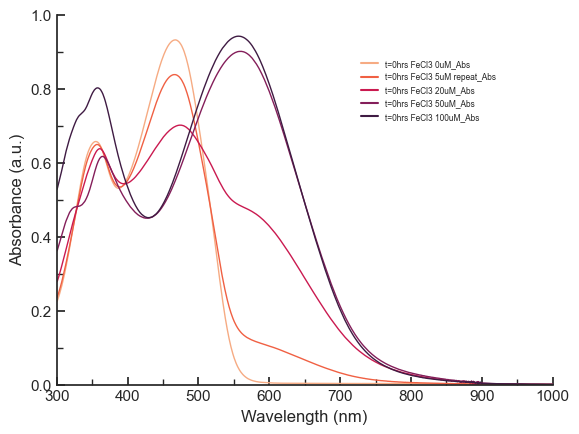

In [15]:
# Plot the data!
# NOTE: User must change the sample names to the correct column names.
sample_name_to_plot: list[str] = [
    "t=0hrs FeCl3 0uM_Abs",
    "t=0hrs FeCl3 5uM repeat_Abs",
    "t=0hrs FeCl3 20uM_Abs",
    "t=0hrs FeCl3 50uM_Abs",
    "t=0hrs FeCl3 100uM_Abs",
]

# If you want to rename, uncomment and insert here!
# sample_name_rename: dict = {"2023_06_22_C10-dialdehyde-chcl3_Abs": "RENAME", "2023_06_22_benzene-diphosphonate1_Abs": "RENAME", "2023_06_22_fluorene-diphosphonate_Abs": "RENAME", "2023_06_22_model-compound_Abs" : "RENAME", "2023_06_22_AU-038-A2-3_Abs" : "RENAME"}
# preprocessed_data = preprocessed_data.rename(columns=sample_name_rename)
# Convert to "tidy" form
plot_data: pd.DataFrame = pd.melt(
    combined_data,
    id_vars=["Wavelength (nm)"],
    value_vars=sample_name_to_plot,
    var_name="sample",
    value_name="Absorbance (a.u.)",
)

# Set correct dtypes
plot_data = plot_data.astype(
    {"Wavelength (nm)": "float32", "sample": "str", "Absorbance (a.u.)": "float32"}
)

# seaborn styles
sns.set_style("ticks")
sns.set_context("notebook") # gives the blank white background theme
# sns.set_theme(context="notebook", style="white", font="Helvetica")

graph = sns.lineplot(
    data=plot_data, # refers to dataframe that contains the data
    x="Wavelength (nm)", # refers to column header to get all the X data
    y="Absorbance (a.u.)", # refers to column header to get all the Y data
    hue="sample",
    palette="rocket_r",  #NOTE: User can change the palette here
    linewidth=style["graph"]["default"]["line_thickness"], # refers to the thickness of the line in the graph (this is set in the style.json file)
)
sns.despine() # this removes the top and right spines of the graph

graph.legend(
    fontsize=style["legend"]["font_size"], # refers to the font size of the legend (this is set in the style.json file)
    bbox_to_anchor=(0.9, 0.9), # refers to the position of the legend anchored in the figure
    title_fontsize=style["legend"]["title_font_size"], # refers to the font size of the legend title
    shadow=False, # refers to whether the legend has a shadow or not
    frameon=False, # refers to whether the legend has a frame or not
)
# font family
plt.rcParams['font.family'] = style["graph"]["default"]["font_family"] # refers to the font family of the text in the graph (this is set in the style.json file)

# y-axis and x-axis ticks
graph.xaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in X-axis
graph.yaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in Y-axis
graph.tick_params(axis="y", direction="in") # direction of major ticks in Y-axis
graph.tick_params(axis="x", direction="in") # direction of major ticks in X-axis
graph.tick_params(axis="y", which="minor", length=4, direction="in") # direction and length of minor ticks in Y-axis
graph.tick_params(axis="x", which="minor", length=4, direction="in") # direction and length of minor ticks in X-axis

# NOTE: User can change the x and y limits here
plt.xlim(300, 1000)
# NOTE: User can change the y limits here
plt.ylim(0, 1.0)

# Save the figure
# NOTE: User can change the filename
plt.savefig("2024_09_11 imine concentration dependent FeCl3 doping.svg", dpi=300, bbox_inches="tight")
plt.savefig("2024_09_11 imine concentration dependent FeCl3 doping.jpg", dpi=300, bbox_inches="tight")